# Fully Conected Neural Network in Pytorch

Data used in this notebook are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

Most of the Pytorch code is adapted from the online course [Deep Learning with PyTorch: Zero to GANs](https://jovian.ml/forum/t/start-here-welcome-to-deep-learning-with-pytorch-zero-to-gans/1622) and Video lectures are available on the [FreeCodeCamp YouTube](https://www.youtube.com/playlist?list=PLWKjhJtqVAbm3T2Eq1_KgloC7ogdXxdRa) channel.

The functions that are used are based on [fast.ai](https://docs.fast.ai/) library which has some [free online courses](https://www.fast.ai/) with great explanations by Jeremy Howard.

# Part 1: Get the data


*   Use `wget` to download the files

*   Use `gunzip` to upack the files into csv

*   Read the csv files into numpy arrays

*   Mount the drive to the colab

*   Pickle the numpy arrays to save space in drive

*   Save the pickles for the next time in the drive




In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

In [ ]:
!gunzip Mirai_dataset.csv.gz
!gunzip Mirai_labels.csv.gz

In [ ]:
import numpy as np

# Load data from csv file
X = np.genfromtxt("Mirai_dataset.csv", delimiter=",")
Y = np.genfromtxt("Mirai_labels.csv", delimiter=",")

In [ ]:
# mount the drive to have access in this colab 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# save the numpy arrays as pickle files (it needs less space than as csv)
import pickle

pickle_X = open("/content/drive/My Drive/X.pickle","wb")
pickle.dump(X, pickle_X)
pickle_X.close()

pickle_y = open("/content/drive/My Drive/y.pickle","wb")
pickle.dump(Y, pickle_y)
pickle_y.close()

## Now to access the data each time just load them from the drive

In [2]:
# mount the drive to have access in this colab 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load the pickle
import pickle
import numpy as np
pickle_X = open("/content/drive/My Drive/X.pickle","rb")
X = pickle.load(pickle_X)

pickle_y = open("/content/drive/My Drive/y.pickle","rb")
Y = pickle.load(pickle_y)

In [4]:
# Remove the first 24 covariates to make the problem more difficult
X = X[:,24:]
X = X.astype(float)
Y = Y.astype(int)

## Quick check
* the length of X and y
* the number of exampels of each class
* if we have NaNs
* because we have impalanced data, check a naive classifier that always predicts class 1

In [5]:
print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
print('The 0 class has {} examples.'.format(len(Y[Y==0])))
print('The 1 class has {} examples.'.format(len(Y[Y==1])))

The covariates have size (764137, 92).
The labels have size (764137,).
The 0 class has 121621 examples.
The 1 class has 642516 examples.


In [6]:
print("The number of NaNs in the labels: {}.".format(np.sum(np.isnan(X))))
print("The number of NaNs in the data: {}.".format(np.sum(np.isnan(Y))))

# Performance of a naive classifier
print('Α naive classifier predicting allways class 1 can obtain {}% accuracy.'.format(round(100*len(Y[Y==1])/len(Y),3)))

The number of NaNs in the labels: 0.
The number of NaNs in the data: 0.
Α naive classifier predicting allways class 1 can obtain 84.084% accuracy.


# Part 2: Preprocessing



*   use sklearn to split the data into train, validation and test sets
*   standardize the data to have mean=0 and sd=1, by subtracting the mean of train data and divide then by the sd of train data
*   convert all sets into torch Tensors
*   out the data into torch DataLoders for convinience in training"



In [7]:
## train test split using sckitlearn (and shuffle)
from sklearn.model_selection import train_test_split
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, test_size=0.3, 
                                                random_state=10, shuffle=True)

Xtest, Xvalid, Ytest, Yvalid = train_test_split(Xtemp, Ytemp, test_size=0.5, 
                                                random_state=10, shuffle=True)


In [8]:
### standardize the data to mean=0 and sd=1
# find the mean and sd for each feature
mu = np.mean(Xtrain, axis=0)
sd = np.std(Xtrain, axis=0)
# standardize the Xtrain
Xtrain = (Xtrain-mu)/sd
# standardize with the same mean and sd
Xvalid = (Xvalid-mu)/sd
Xtest = (Xtest-mu)/sd

In [9]:
print('Τrain set, {}: 0 class and {}: 1 class.'.format(np.bincount(Ytrain)[0],np.bincount(Ytrain)[1]))
print('Valid set, {}: 0 class and {}: 1 class.'.format(np.bincount(Yvalid)[0],np.bincount(Yvalid)[1]))
print('Τest  set, {}: 0 class and {}: 1 class.'.format(np.bincount(Ytest)[0],np.bincount(Ytest)[1]))

Τrain set, 85168: 0 class and 449727: 1 class.
Valid set, 18106: 0 class and 96515: 1 class.
Τest  set, 18347: 0 class and 96274: 1 class.


## Convert the data into torch Tensors and load data to GPU

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import time
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
## transform numpy arrays to Tensors
Xtrain = torch.from_numpy(Xtrain).float()
Ytrain = torch.from_numpy(Ytrain)

Xvalid = torch.from_numpy(Xvalid).float()
Yvalid = torch.from_numpy(Yvalid)

Xtest = torch.from_numpy(Xtest).float()
Ytest = torch.from_numpy(Ytest)

In [16]:
BATCH_SIZE = 8192 #1024

# Pytorch TensorDatasets
train = torch.utils.data.TensorDataset(Xtrain, Ytrain)
valid = torch.utils.data.TensorDataset(Xvalid, Yvalid)
test  = torch.utils.data.TensorDataset(Xtest, Ytest)

# Pytorch DataLoader
#shuffle=True i.e. in every epoch each batch has different observations, helps stochasticity
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE*2, num_workers=3, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE*2, num_workers=3, pin_memory=True)

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
# load data
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(valid_loader, device)

# Part 3: Pytorch Model

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ClassificationBase(nn.Module):
    def training_step(self, batch):
        inputs, labels = batch 
        out = self(inputs)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, labels = batch 
        out = self(inputs)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [21]:
class DNNmodel(ClassificationBase):
  def __init__(self, num_features, num_hidden1, num_hidden2,num_classes, drop_proba):
    super(DNNmodel, self).__init__()
    self.drop_proba = drop_proba
    # 1st hidden layer
    self.linear_1 = torch.nn.Linear(num_features, num_hidden1)
    self.linear_1_bn = torch.nn.BatchNorm1d(num_hidden1)
    # 2nd layer
    self.linear_2 = torch.nn.Linear(num_hidden1, num_hidden2)
    self.linear_2_bn = torch.nn.BatchNorm1d(num_hidden2)
    # Output layer
    self.linear_out = torch.nn.Linear(num_hidden2, num_classes)

  def forward(self, x):
    out = self.linear_1(x)
    out = self.linear_1_bn(out)
    out = F.relu(out)
    out = F.dropout(out, p=self.drop_proba, training=self.training)
    out = self.linear_2(out)
    out = self.linear_2_bn(out)
    out = F.relu(out)
    out = F.dropout(out, p=self.drop_proba, training=self.training)
    out = self.linear_out(out)
    return out

model = DNNmodel(92, 20, 20, 2, drop_proba=0.2)

In [22]:
# The architecture of the fully connected network
model

DNNmodel(
  (linear_1): Linear(in_features=92, out_features=20, bias=True)
  (linear_1_bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_2): Linear(in_features=20, out_features=20, bias=True)
  (linear_2_bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_out): Linear(in_features=20, out_features=2, bias=True)
)

In [23]:
# load model to GPU
to_device(model, device);

# Part 4: Training

In [58]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def adjust_learning_rate(optimizer, decay=0.2):    
    for param_group in optimizer.param_groups:
      param_group['lr'] = decay * param_group['lr']
      print(f"New learning rate: {param_group['lr']}")

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Decaying Learning Rate
        if epoch>20 and not (epoch)%3:
            adjust_learning_rate(optimizer)
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [59]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.01

In [60]:
# if need to reinitialize the weights
model = DNNmodel(92, 20, 20, 2, drop_proba=0.2)
to_device(model, device);

In [61]:
# with the initial random weight we get validation accuracy
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.8413321375846863, 'val_loss': 0.6529019474983215}]

In [62]:
%%time
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.2154, val_loss: 0.1619, val_acc: 0.9140
Epoch [1], train_loss: 0.1593, val_loss: 0.1515, val_acc: 0.9180
Epoch [2], train_loss: 0.1548, val_loss: 0.1487, val_acc: 0.9180
Epoch [3], train_loss: 0.1526, val_loss: 0.1472, val_acc: 0.9190
Epoch [4], train_loss: 0.1507, val_loss: 0.1486, val_acc: 0.9185
Epoch [5], train_loss: 0.1497, val_loss: 0.1451, val_acc: 0.9187
Epoch [6], train_loss: 0.1491, val_loss: 0.1444, val_acc: 0.9200
Epoch [7], train_loss: 0.1489, val_loss: 0.1429, val_acc: 0.9210
Epoch [8], train_loss: 0.1478, val_loss: 0.1453, val_acc: 0.9236
Epoch [9], train_loss: 0.1458, val_loss: 0.1398, val_acc: 0.9268
Epoch [10], train_loss: 0.1444, val_loss: 0.1432, val_acc: 0.9259
Epoch [11], train_loss: 0.1460, val_loss: 0.1376, val_acc: 0.9265
Epoch [12], train_loss: 0.1427, val_loss: 0.1362, val_acc: 0.9289
Epoch [13], train_loss: 0.1418, val_loss: 0.1371, val_acc: 0.9282
Epoch [14], train_loss: 0.1415, val_loss: 0.1344, val_acc: 0.9306
Epoch [15], train_lo

In [63]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

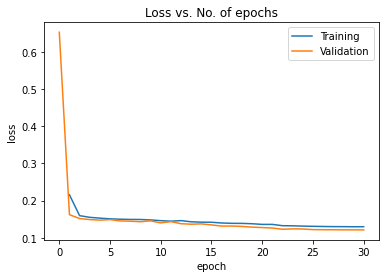

In [64]:
plot_losses(history)

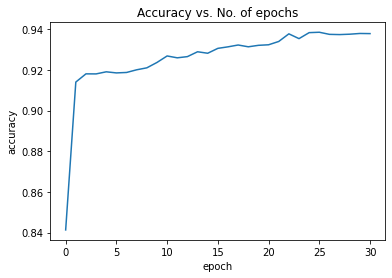

In [67]:
plot_accuracies(history)

## Test how the model generalize (test accuracy).

In [68]:
test_dl = DeviceDataLoader(test_loader, device)

In [69]:
tst_logs = evaluate(model, test_dl)

In [70]:
print("Test accuracy: {} and test loss: {}.".format(np.round(tst_logs['val_acc']*100, 2),np.round(tst_logs['val_loss'], 2)))

Test accuracy: 93.91 and test loss: 0.12.


# References:


1.   [fast.ai](https://www.fast.ai/)
2.   [Kitsune Network Attack Dataset Data Set. UCI](https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset)
3.   [Deep Learning with PyTorch: Zero to GANs](https://jovian.ml/forum/t/start-here-welcome-to-deep-learning-with-pytorch-zero-to-gans/1622)
4.   [Sebastian Raschka, STAT 453, University of Wisconsin-Madison]( https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/mlp/mlp-dropout.ipynb)

